In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats
from tqdm import tqdm

In [4]:
def compute_leading_fin(l_peaks_array, r_peaks_array):
    """
    Compares the first column of two matrices row-wise and outputs an array
    with annotations:
    - 0 if the left value is smaller,
    - 1 if the right value is smaller,
    - 2 if both values are equal.
    
    Parameters:
    - l_peaks_array: 2D numpy array, where we compare the first column.
    - r_peaks_array: 2D numpy array, where we compare the first column.
    
    Returns:
    - result: 1D numpy array with annotation results for each row.
    """
    # Ensure the shapes of the arrays match and have at least one column
    if l_peaks_array.shape[0] != r_peaks_array.shape[0] or l_peaks_array.shape[1] == 0 or r_peaks_array.shape[1] == 0:
        raise ValueError("The arrays must have the same number of rows and at least one column.")

    num_rows = l_peaks_array.shape[0]
    result = np.zeros(num_rows, dtype=int)

    for i in range(num_rows):
        left_value = l_peaks_array[i, 0]
        right_value = r_peaks_array[i, 0]

        if left_value < right_value:
            result[i] = 0
        elif right_value < left_value:
            result[i] = 1
        else:
            result[i] = 2
    
    return result

In [5]:
def extract_durations(r_peaks_i_array, r_valleys_i_array, r_peaks_a_array, r_valleys_a_array, thr=0.2, thr_last=0.1):
    ref = np.concatenate((r_peaks_a_array, r_valleys_a_array), axis=1)
    test = np.concatenate((r_peaks_i_array, r_valleys_i_array), axis=1)
    
    starts = []
    ends = []
    durations = []
    
    for i in range(test.shape[0]):
        current_test = test[i]
        current_ref = ref[i]
        
        # Calculate start and end
        start_r = np.nanmin(current_test) if np.any(~np.isnan(current_test)) else 0
        end_r = np.nanmax(current_test) if np.any(~np.isnan(current_test)) else 0
        
        # Check the amplitude of the first point
        first_point_index = np.nanargmin(current_test) if np.any(~np.isnan(current_test)) else 0
        first_point_amplitude = current_ref[first_point_index]
        
        if abs(first_point_amplitude) > thr:
            start_r = 0
            
            # Initialize a flag for the second peak
            second_peak_found = False
            
            # Iterate through amplitudes after the first point
            for j in range(first_point_index + 1, len(current_ref)):
                amplitude_diff = abs(current_ref[j] - current_ref[j-1])
                
                if not second_peak_found:
                    # Allow finding the second peak
                    if amplitude_diff > thr_last:
                        second_peak_found = True
                else:
                    # If second peak is found, ignore small amplitude differences
                    if amplitude_diff < thr_last:
                        current_test[j] = np.nan  # Ignore this point in min/max calculation
        
            # Re-calculate end based on the modified test array
            end_r = np.nanmax(current_test) if np.any(~np.isnan(current_test)) else 0
        
        # Calculate duration
        dur_r = end_r - start_r
        
        starts.append(start_r)
        ends.append(end_r)
        durations.append(dur_r)
    
    return np.array(starts), np.array(ends), np.array(durations)


In [6]:
# def compute_laterality(peaks_a_array, valleys_a_array):
#     lateralities = np.full(peaks_a_array.shape[0],np.nan)
#     # Access the first row of each array
#     for bout in range(peaks_a_array.shape[0]):
#         peaks_first = peaks_a_array[bout, 0]
#         valleys_first = valleys_a_array[bout, 0]
#         # Compare and determine laterality
#         laterality = np.where( np.abs(peaks_first) > np.abs(valleys_first), 0, 1)
#         lateralities[bout]= laterality
#     return lateralities
    
#     print("Laterality:", laterality)

def tail_oscillations_with_laterality(peaks_a_array, valleys_a_array, laterality):
    """
    Counts the total number of non-NaN elements per row in peaks_array or valleys_array
    based on the laterality for each element.
    
    Parameters:
    - peaks_a_array: 2D numpy array of peak values.
    - valleys_a_array: 2D numpy array of valley values.
    - laterality: 1D numpy array indicating laterality (0 or 1).
    
    Returns:
    - total_non_nan_count: 1D numpy array with the total count of non-NaN elements per row
      based on laterality.
    """
    total_non_nan_count = np.zeros(peaks_a_array.shape[0], dtype=float)  # Use float type

    # Count non-NaN elements based on laterality
    for i, lat in enumerate(laterality):
        if lat == 1: #0:  # "left"
            for j in range(peaks_a_array.shape[1]):
                if not np.isnan(peaks_a_array[i, j]):
                    total_non_nan_count[i] += 1
        else:  # "right"
            for j in range(valleys_a_array.shape[1]):
                if not np.isnan(valleys_a_array[i, j]):
                    total_non_nan_count[i] += 1

    return total_non_nan_count

In [7]:
def combine_and_sort_indices(peaks_i_array, valleys_i_array):
    """
    Combines and sorts peaks and valleys indices for each row, ignoring NaNs.
    
    Parameters:
    - peaks_i_array: 2D numpy array of peaks indices.
    - valleys_i_array: 2D numpy array of valleys indices.
    
    Returns:
    - sorted_indices_array: 2D numpy array with sorted indices for each row.
    """
    num_rows, num_cols = peaks_i_array.shape
    sorted_indices_array = np.full((num_rows, num_cols * 2), np.nan, dtype=float)

    for row in range(num_rows):
        # Combine peaks and valleys, ignoring NaNs
        combined_indices = np.concatenate((peaks_i_array[row], valleys_i_array[row]))
        valid_indices = combined_indices[~np.isnan(combined_indices)].astype(int)
        
        # Sort the combined indices
        sorted_indices = np.sort(valid_indices)
        
        # Store the sorted indices in the output array
        sorted_indices_array[row, :len(sorted_indices)] = sorted_indices

    return sorted_indices_array

def calculate_periods_between_peaks(peaks_i_array, fps):
    """
    Calculates the periods (in seconds) between peaks for each row in the peaks_i_array, 
    maintaining the original shape of the array.
    
    Parameters:
    - peaks_i_array: 2D numpy array where each row contains indices of peaks.
    - fps: Frames per second of the sampling rate.
    
    Returns:
    - periods_array: 2D numpy array with the same shape as peaks_i_array, where each row
      contains the periods between successive peaks, and remaining positions are NaN.
    """
    num_rows, num_cols = peaks_i_array.shape
    periods_array = np.full((num_rows, num_cols), np.nan, dtype=float)

    for row in range(num_rows):
        peak_indices = peaks_i_array[row]
        # Remove NaN values and convert to integers
        valid_indices = peak_indices[~np.isnan(peak_indices)].astype(int)

        # Calculate the differences between successive peak indices
        if len(valid_indices) > 1:
            frame_differences = np.diff(valid_indices)
            # Convert frame differences to time periods in seconds
            periods = frame_differences / fps
            # Copy periods to the corresponding row in the output array
            periods_array[row, :len(periods)] = periods

    return periods_array

In [8]:
from skimage.filters import threshold_otsu

def extract_extrema(arr): 
    """Extract indices where extrema are found in a tail or fin trace.

    :param arr: tail of fin trace
    :return: list of indices where minima and maxima are found.
    """

    idxs = np.arange(arr.shape[0])

    min_idxs = []
    max_idxs = []

    for i in range(1, arr.shape[0] - 1):
        if arr[i - 1] < arr[i] > arr[i + 1]:
            max_idxs.append(i)
        elif arr[i - 1] > arr[i] < arr[i + 1]:
            min_idxs.append(i)

    return min_idxs, max_idxs
    
    
def moving_average(a, n=2):
    """Compute rolling average on a given array.

    :param a: array
    :param n: size of rolling window
    :return: new array
    """

    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def compute_tbf(traces, extract_extrema, moving_average, dt=1.0, threshold=0.2, min_valid_tps=5):
    """
    Computes the TBF (time between features) for each trace based on extrema.

    Parameters:
    - traces: The 3D numpy array containing the traces to analyze.
    - extract_extrema: A function that returns the minima and maxima of a trace.
    - moving_average: A function that calculates the moving average of an array.
    - dt: Time step duration (default is 1.0).
    - threshold: The threshold for considering significant extrema changes (default is 0.2).
    - min_valid_tps: Minimum number of time points required for valid TBF computation (default is 5).

    Returns:
    - tbf_output: The computed TBF values for the input traces.
    """
    tbf_output_list = []

    for fin in range(traces.shape[1]):
        extrema_idxs = []

        for trace in traces[:, fin, :]:
            # Identify extrema
            mins, maxs = extract_extrema(trace)
            
            # Combine and sort indexes, add first and last timepoints
            extrema = np.sort(np.concatenate((np.array(mins), np.array(maxs))))
            extrema = np.insert(extrema, 0, 0)
            extrema = np.append(extrema, trace.shape[-1] - 1)

            # Normalize trace and compute average difference for each extrema
            trace_norm = (trace - trace.min()) / (trace.max() - trace.min())
            extrema_y = [trace_norm[i] for i in extrema]
            extrema_diff = np.abs(np.diff(extrema_y))
            avg_extrema_diff = moving_average(extrema_diff)

            # Append extrema if their average change is larger than the threshold
            extrema_idxs.append(extrema[1:-1][avg_extrema_diff > threshold])

        # Compute TBFs
        idxs = np.arange(traces.shape[2])
        tbf_output = np.full((traces.shape[0], idxs.shape[0]), np.nan)

        for i, extrema in enumerate(extrema_idxs):
            if len(extrema) > 1:  # To avoid issues with min() and max() on empty arrays
                valid_idxs = idxs[np.logical_and(idxs >= min(extrema), idxs < max(extrema))]

                if len(valid_idxs) > min_valid_tps:
                    time_diffs = np.diff(extrema) * dt
                    binned_tps = np.digitize(valid_idxs, extrema) - 1
                    instant_time_diff = np.array([time_diffs[i] for i in binned_tps])
                    tbf = (1 / instant_time_diff) / 2
                    tbf_output[i, valid_idxs[0]:valid_idxs[-1] + 1] = tbf

        tbf_output_list.append(tbf_output)

    return np.stack(tbf_output_list)

In [9]:
def resort_ipsi_contra(tail, left_fin, right_fin, directionality):
    """
    Resorts left_fin, right_fin, left_eye, and right_eye based on directionality
    into ipsilateral and contralateral components.
    """
    tail_new = np.zeros_like(tail)
    ipsi_fin = np.zeros_like(left_fin)
    contra_fin = np.zeros_like(left_fin)
    ipsi_fin_id = np.zeros(len(left_fin))  # Initialize with 0 (for 'left')

    for i, dir_value in enumerate(directionality):
        if dir_value == 1:  # Left direction
            tail_new[i] = tail[i]
            ipsi_fin[i] = left_fin[i]
            contra_fin[i] = right_fin[i]
            ipsi_fin_id[i] = 0  # Set as 0 (for 'left')
        elif dir_value == -1: #0:  # Right direction
            tail_new[i] = tail[i]
            ipsi_fin[i] = right_fin[i]
            contra_fin[i] = left_fin[i]
            ipsi_fin_id[i] = 1  # Set as 1 (for 'right')
    return tail_new, ipsi_fin, contra_fin,  ipsi_fin_id



def sort_tensor_ipsi_contra(tensor, directionality):
    """
    Sort the tensor signals into ipsilateral and contralateral components
    based on the detected directionality.

    Args:
    tensor (np.ndarray): The baseline-corrected tensor of shape (trials, signals, time points).

    Returns:
    tuple: The sorted and adjusted tensor, ipsilateral fin identities, 
           and indices of trials where fins were switched.
    """
    # Extract each signal
    tail = tensor[:, 0, :]
    left_fin = tensor[:, 1, :]
    right_fin = tensor[:, 2, :]

    # Resort fins and eyes into ipsilateral and contralateral components
    tail_new, ipsi_fin, contra_fin, ipsi_fin_id = resort_ipsi_contra(
       tail, left_fin, right_fin, directionality
    )
    
    # Create a new tensor with sorted and adjusted components
    new_tensor = np.stack([tail_new, ipsi_fin, contra_fin], axis=1)
    
    return new_tensor, ipsi_fin_id

In [10]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array

## Load data

In [11]:
# master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

# fish_paths = list(master_path.glob('*f[0-9]*'))
# fish_paths

In [12]:

# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\230307_visstim_2D") #rectangular arena # start from fish 1
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_round")
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_2") #rectangular arena
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\13052024_visstim_2D_round")
master_path = Path(r"\\portulab.synology.me\data\Kata\Data\14052024_visstim_2D_round")

In [13]:
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)

([WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f1'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f2'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f3'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f4'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f5'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f6'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f7'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f8'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f9')],
 10)

In [14]:
fish= 2
fish_id =  fish_paths[fish].name
exp_name = Path(fish_paths[fish]).parts[-2]
# exp_name = 'testfish'
fish_id, exp_name


('240514_f2', '14052024_visstim_2D_round')

In [15]:
# out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

In [16]:
## Analysed for paper

# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\230307_visstim_2D_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_round_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_2_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\13052024_visstim_2D_round_")
out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\14052024_visstim_2D_round_")

In [17]:
save_data_path = out_path

## Loop

In [18]:
max_n = 9
fps = 200

In [19]:


traces =  fl.load(out_path / '{}_tensor.h5'.format(fish_id))
bout_data = fl.load(out_path/'{}_bout_data.h5'.format(fish_id))
laterality = fl.load(out_path/ '{}_bout_laterality.h5'.format(fish_id))

print(traces.shape, np.unique(laterality))

t_feature_vector_array = fl.load(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id))
l_feature_vector_array = fl.load(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id))
r_feature_vector_array = fl.load(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id))

t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(t_feature_vector_array)
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(l_feature_vector_array)
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(r_feature_vector_array)

leading_fin = compute_leading_fin(l_peaks_i_array, r_peaks_i_array)
print("Comparison result:", np.unique(leading_fin))

# fl.save(save_data_path/ '{}_leading_fin.h5'.format(fish_id),leading_fin)

sorted_tensor, ipsi_fin_ids = sort_tensor_ipsi_contra(traces, laterality)
print (sorted_tensor.shape)
print("Ipsilateral fin identities:", np.unique(ipsi_fin_ids))

# fl.save(save_data_path/ '{}_tensor_ipsi_contra.h5'.format(fish_id), sorted_tensor)
# fl.save(save_data_path/ '{}_ipsi_fin_ids.h5'.format(fish_id), ipsi_fin_ids)


(40, 3, 50) [-1.  1.]
Reshaped array shape: (40, 4, 9)
Reshaped array shape: (40, 4, 9)
Reshaped array shape: (40, 4, 9)
Comparison result: [0 1 2]
(40, 3, 50)
Ipsilateral fin identities: [0. 1.]


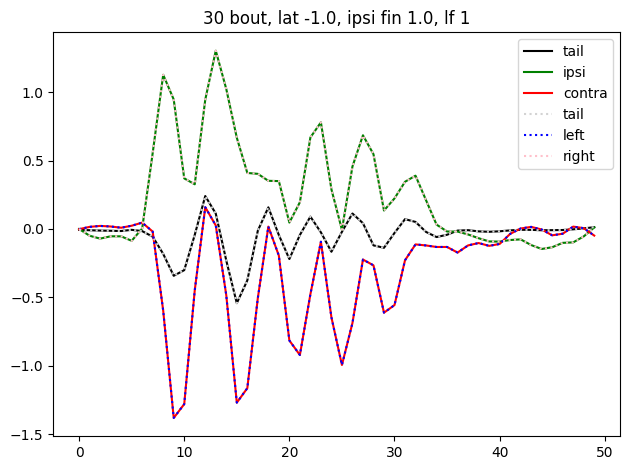

In [41]:
# Generate a random integer from 0 to num_elements - 1
bout =  np.random.randint(0, np.asarray(traces).shape[0])
plt.figure()
plt.title(f'{bout} bout, lat {laterality[bout]}, ipsi fin {ipsi_fin_ids[bout]}, lf {leading_fin[bout]}')
plt.plot(np.asarray(sorted_tensor)[bout, 0, :], c='k', label='tail')
plt.plot(np.asarray(sorted_tensor)[bout,1, :], c='g', label='ipsi')
plt.plot(np.asarray(sorted_tensor)[bout,2, :], c='r', label='contra')

plt.plot(np.asarray(traces)[bout, 0, :], ls=':',  c='lightgray', label='tail' )
plt.plot(np.asarray(traces)[bout, 1, :], ls=':',  c='blue', label='left')
plt.plot(np.asarray(traces)[bout, 2, :], ls=':',  c='pink', label='right')
plt.legend()

plt.tight_layout()

In [36]:
sorted_tensor.shape

(40, 3, 50)